# Environment

In [1]:
#! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

LANGSMITH_API_KEY  = os.getenv("LANGSMITH_API_KEY")

In [3]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = LANGSMITH_API_KEY

GEMINI API key

In [4]:
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
os.environ['GOOGLE_API_KEY'] = GEMINI_API_KEY

# 1. Indexing

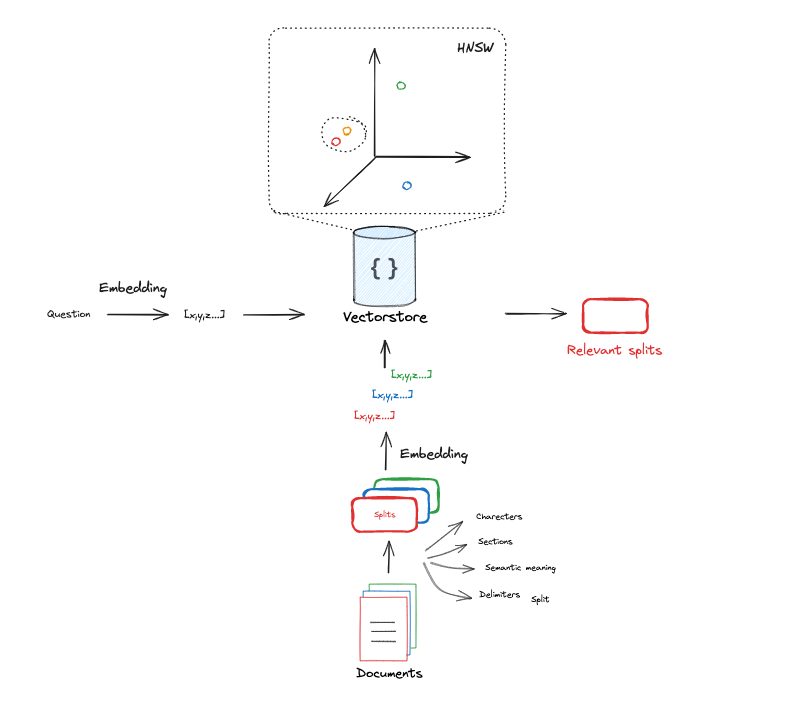

In [5]:
# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

Text embedding

In [6]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
query_result  = embeddings.embed_query(question)
document_result =  embeddings.embed_query(document)
len(query_result)

3072

In [7]:
query_result[:5], document_result[:5]

([-0.006734609138220549,
  -2.607288251965656e-07,
  0.01740053854882717,
  -0.06316135078668594,
  0.008764837868511677],
 [-0.01824170909821987,
  0.01861375756561756,
  0.021020900458097458,
  -0.08642136305570602,
  0.0007866863743402064])

applying cosine similarity

In [8]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)

Cosine Similarity: 0.9015230867829924


In [9]:
#### INDEXING ####

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [10]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

In [11]:
splits[:2]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [12]:
# Index
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001"))

retriever = vectorstore.as_retriever()

# 2.Retrievel 

In [14]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(documents=splits, 
                                    embedding=GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001"))

retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.

In [20]:
docs = retriever.invoke("What is Task Decomposition?")
docs[:5]

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a

In [21]:
len(docs)

1

# 3. Generation

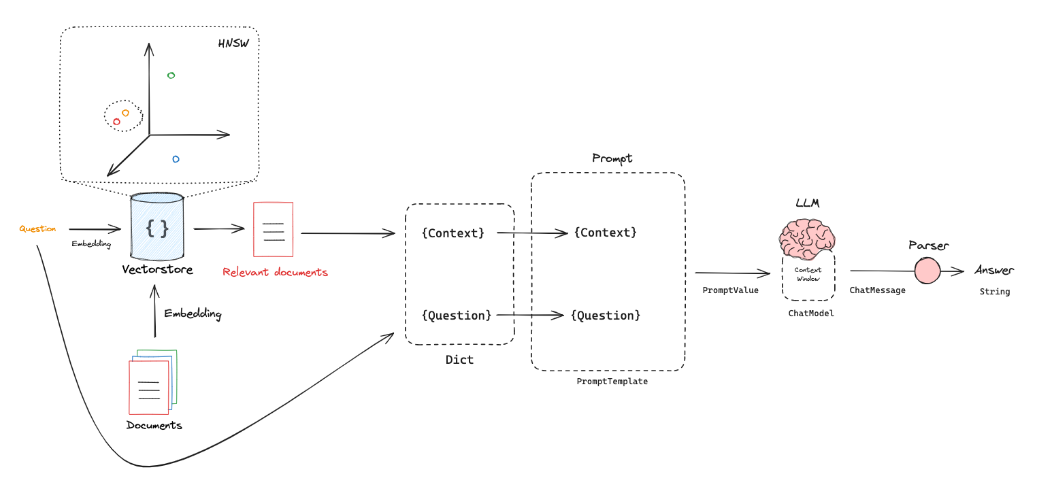

creating prompt template

In [22]:
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [23]:
# Import Gemini LLM from langchain_google_genai
from langchain_google_genai import ChatGoogleGenerativeAI

# LLM:
llm = ChatGoogleGenerativeAI(model="models/gemini-1.5-flash")

In [24]:
# Chain
chain = prompt | llm

In [25]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"})

AIMessage(content='Based on the provided text, task decomposition is the process of breaking down a complex task into smaller, simpler steps.  This can be achieved through prompting techniques like Chain of Thought (CoT) or Tree of Thoughts, or by using task-specific instructions or human input.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []}, id='run--3cb6ad05-85c3-457e-bbad-f7dd74450479-0', usage_metadata={'input_tokens': 324, 'output_tokens': 56, 'total_tokens': 380, 'input_token_details': {'cache_read': 0}})

In [26]:
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")

In [27]:
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

[Rag Chains](https://python.langchain.com/docs/expression_language/get_started#rag-search-example)

StrOutputParser — Takes the LLM’s output (which might be a structured LangChain object) and extracts just the plain string.
RunnablePassthrough — A LangChain component that does nothing except pass its input through untouched (like a “pipe” in plumbing).

### Why this pattern is used ?
Modular — easy to swap retriever, prompt, or llm without touching other parts.

Parallel — retriever and passthrough run in parallel for efficiency.

Modern LangChain syntax — no get_relevant_documents() warnings, future-proof.

In [28]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Based on the provided text, task decomposition is the process of breaking down a complicated task into smaller, simpler steps.  This can be done using techniques like Chain of Thought (CoT), which instructs the model to think step-by-step, or Tree of Thoughts, which explores multiple reasoning possibilities at each step, creating a tree structure.  It can also be achieved through simple prompts, task-specific instructions, or human input.'